1. [Открытие данных](#start)
2. [Предобработка данных](#preprocessing)
3. [Основная часть](#work)
    * [Изучение и проверка данных](#part0)
    * [Количество событий в логе](#part1)
    * [Количество пользователей в логе](#part2)
    * [Среднее количество событий на одного пользователя](#part3)
    * [Изучение периодов данных](#part4)
    * [Изучение воронки событий](#part5)
    * [Изучение событий в логах.](#part6)
    * [Воронка продаж с учетом последовательности событий.](#part7)
    * [Проведение AA, A/B-экспериментов.](#part8)
    * [Предварительные расчеты](#part9)
    * [Проведение А/А-эксперимента](#part10)
    * [Проведение A/B-эксперимента.](#part11)
4. [Выводы](#end)

<a id="start"></a>
### Открытие данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as st
import math as mth
import datetime as dt

In [2]:
path = 'C:/Users/sokolovae/Documents/project/'

In [3]:
df = pd.read_csv(path + 'logs_exp.csv', sep='\t')

In [4]:
df.head()

,",EventName",DeviceIDHash,EventTimestamp,ExpId
0,"0,MainScreenAppear",4575588528974610257,1564029816,246
1,"1,MainScreenAppear",7416695313311560658,1564053102,246
2,"2,PaymentScreenSuccessful",3518123091307005509,1564054127,248
3,"3,CartScreenAppear",3518123091307005509,1564054127,248
4,"4,PaymentScreenSuccessful",6217807653094995999,1564055322,248


<a id="preprocessing"></a>
### Предобработка данных

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
,EventName        244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [6]:
df.columns = ['event_name', 'uid', 'time', 'exp_id']

In [7]:
df.head()

,event_name,uid,time,exp_id
0,"0,MainScreenAppear",4575588528974610257,1564029816,246
1,"1,MainScreenAppear",7416695313311560658,1564053102,246
2,"2,PaymentScreenSuccessful",3518123091307005509,1564054127,248
3,"3,CartScreenAppear",3518123091307005509,1564054127,248
4,"4,PaymentScreenSuccessful",6217807653094995999,1564055322,248


In [8]:
#Приведем столбец с датой в таблице в формат даты:
df['date'] = pd.to_datetime(df['time'], unit = 's')

In [9]:
df.duplicated().sum()

0

In [10]:
#Создадим столбцы с категоризацией даты по периодам(день, месяц, неделя):
df['day'] = df['date'].dt.floor('D')
df['week'] = df['date'].astype('datetime64[W]')
df['month'] = df['date'].astype('datetime64[M]')

In [11]:
df.head()

,event_name,uid,time,exp_id,date,day,week,month
0,"0,MainScreenAppear",4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25,2019-07-25,2019-07-01
1,"1,MainScreenAppear",7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25,2019-07-25,2019-07-01
2,"2,PaymentScreenSuccessful",3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25,2019-07-25,2019-07-01
3,"3,CartScreenAppear",3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25,2019-07-25,2019-07-01
4,"4,PaymentScreenSuccessful",6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25,2019-07-25,2019-07-01


<a id="work"></a>
## Основная часть

### Изучение и проверка данных <a id="part0"></a>

#### Количество событий в логе <a id="part1"></a>

In [12]:
len(df)

244126

<a id="part2"></a>
#### Количество пользователей в логе

In [13]:
df['uid'].nunique()

7551

<a id="part3"></a>
#### Среднее количество событий на одного пользователя

In [14]:
len(df)/(df['uid'].nunique())

32.33028737915508

В логе всего 244126 событий, 7551 уникальных пользователя. На каждого пользователя в среднем приходится примерно 32 события.

#### Изучение периодов данных <a id="part4"></a>

In [15]:
#Найдем самую раннюю дату в логе
df['date'].min()

Timestamp('2019-07-25 04:43:36')

In [16]:
#Найдем самую позднюю дату в логе
df['date'].max()

Timestamp('2019-08-07 21:15:17')

In [17]:
#Найдем сколько всего уникальных дат
df['day'].nunique()

14

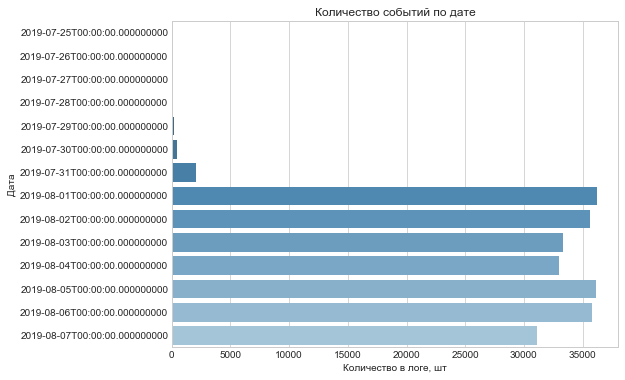

In [18]:
# Построим график распределения событий по дате:
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
ax = sns.countplot(y= 'day', data = df, 
                  palette = 'Blues_d')
ax.set(xlabel = 'Количество в логе, шт')
ax.set(ylabel = 'Дата')
ax.set_title('Количество событий по дате')
plt.show()

На основании графика можно сделать вывод о том, что полные данные у нас только за период с 01 августа по 07 августа 2019 года. Их и нужно принимать в расчет.

In [19]:
#Посчитаем сколько всего событий было "потеряно" в неполных данных
len(df.query('day < "2019-08-01"'))

2828

In [20]:
#Найдем долю событий в неполных данных ко всему объему лога событий
len(df.query('day < "2019-08-01"'))/len(df)

0.011584181938834865

In [21]:
#Найдем количество уникальных пользователей, которых мы потеряли в неполных данных
df['uid'].nunique() - df.query('day > "2019-07-31"')['uid'].nunique()

17

In [22]:
#Найдем долю уникальных пользователей, которых мы потеряли в неполных данных
(df['uid'].nunique() - df.query('day > "2019-07-31"')['uid'].nunique())/df['uid'].nunique() 

0.0022513574361011784

В неполных данных чуть более 1% лога событий и примерно 0,2% уникальных пользователей.

### Изучение воронки событий <a id="part5"></a>


In [23]:
df = df.query('day > "2019-07-31"').copy() # убираем неполные данные

In [24]:
df.head()

,event_name,uid,time,exp_id,date,day,week,month
2828,"2828,Tutorial",3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01,2019-08-01,2019-08-01
2829,"2829,MainScreenAppear",3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01,2019-08-01,2019-08-01
2830,"2830,MainScreenAppear",3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01,2019-08-01,2019-08-01
2831,"2831,OffersScreenAppear",3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01,2019-08-01,2019-08-01
2832,"2832,MainScreenAppear",1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01,2019-08-01,2019-08-01


#### Изучение событий в логах <a id="part6"></a>

In [25]:
df['event_name'].value_counts().sort_values(ascending = False).head()# в названии события задублировались индексы

242428,PaymentScreenSuccessful    1
15075,MainScreenAppear            1
52571,MainScreenAppear            1
90479,OffersScreenAppear          1
213572,PaymentScreenSuccessful    1
Name: event_name, dtype: int64

In [26]:
# Для удаления индексов из названия событий напишем функцию, которая на вход берет название события,\
#а на выход выдает только значения после запятой
def find_log(event_name):
    start = event_name.find(',')
    event = event_name[start+1:]
# возвращаем название улицы без пробелов и дополнительных знаков    
    return event.strip()

In [27]:
find_log('2828,Tutorial')

'Tutorial'

In [28]:
# Применяем функцию к столбцу с событиями
df['event_name_true'] = df['event_name'].apply(np.vectorize(find_log))

In [29]:
df.head()

,event_name,uid,time,exp_id,date,day,week,month,event_name_true
2828,"2828,Tutorial",3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01,2019-08-01,2019-08-01,Tutorial
2829,"2829,MainScreenAppear",3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01,2019-08-01,2019-08-01,MainScreenAppear
2830,"2830,MainScreenAppear",3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01,2019-08-01,2019-08-01,MainScreenAppear
2831,"2831,OffersScreenAppear",3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01,2019-08-01,2019-08-01,OffersScreenAppear
2832,"2832,MainScreenAppear",1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01,2019-08-01,2019-08-01,MainScreenAppear


In [30]:
df['event_name_true'].value_counts().sort_values(ascending = False).reset_index()

,index,event_name_true
0,MainScreenAppear,117431
1,OffersScreenAppear,46350
2,CartScreenAppear,42365
3,PaymentScreenSuccessful,34113
4,Tutorial,1039


Самое большое количество событий приходится на MainScreenAppear(переход клиентов на главную страницу сайта), затем идет OffersScreenAppear(переход на экран с предложениями), после него CartScreenAppear(переход в корзину с покупками), далее PaymentScreenSuccessful (подтверждение об оплате). 

Наименьшее количество событий приходится на Tutorial. На мой взгляд, это переход клиентов на станицу с помощью(руководством) по сайту, что может свидетельствовать о технических проблемах сайта.

In [31]:
# Посчитаем количество уникальных клиентов на каждом этапе воронки:
df_gr = df.pivot_table(index = 'event_name_true', values = 'uid', aggfunc = 'nunique').sort_values('uid', ascending = False)
del df_gr['event_name_true']
df_gr.reset_index()

,event_name_true,uid
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [32]:
# Найдем долю клиентов на каждом жтапе воронки продаж от общего числа клиентов:
df_gr['ratio'] = df_gr['uid']/df['uid'].nunique()
df_gr

,uid,ratio
event_name_true,,
MainScreenAppear,7419,0.984736
OffersScreenAppear,4593,0.609636
CartScreenAppear,3734,0.495620
PaymentScreenSuccessful,3539,0.469737
Tutorial,840,0.111495


На этом этапе все выглядит вполне неплохо, почти 47% от общего числа пользователей сайта совершили покупку. Единственное, что смущает, что 11% пользователей обратилось за помощью. Это может свидетельствовать о проблемах техничесткого характера с выбором/оплатой товаров на сайте.

#### Воронка продаж с учетом последовательности событий <a id="part7"></a>

In [33]:
# Создадим таблицу, где в качестве строк будут уникальные клиенты, \
# а в качестве столбцов - ивенты событий(посещение сайта, оплата товара)
users = df.pivot_table(
    index='uid', 
    columns='event_name_true', 
    values='date',
    aggfunc='min').reset_index()

# На первом шаге выберем клиентов, которые посещали сайт. 
# На последующих шахаг найдем клиентов, которые посещали сайт и перешли к выбору товара и т.д.:
step_1 = ~users['MainScreenAppear'].isna()
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

# Найдем количество елиентов на каждом этапе:
n_MainScreenAppear = len(users[step_1])
n_OffersScreenAppear = users[step_2].shape[0]
n_CartScreenAppear = users[step_3].shape[0]
n_PaymentScreenSuccessful = users[step_4].shape[0]

print('Посетителей:', n_MainScreenAppear)
print('Выбирали товар:', n_OffersScreenAppear)
print('Добавили товар в корзину:', n_CartScreenAppear)
print('Оплатили:', n_PaymentScreenSuccessful)

print('Доля клиентов, которые выбирали товар от числа посетителей:', n_OffersScreenAppear/n_MainScreenAppear)
print('Доля клиентов, которые добавили товар в корзину от тех, кто выбирал товар:', n_CartScreenAppear/n_OffersScreenAppear)
print('Доля клиентов, кто оплатил товар от тех, кто добавил товар в корзину:', n_PaymentScreenSuccessful/n_CartScreenAppear)
print('Доля клиентов, кто оплатил товар от числа посетителей сайта:', n_PaymentScreenSuccessful/n_MainScreenAppear)


Посетителей: 7419
Выбирали товар: 4201
Добавили товар в корзину: 1767
Оплатили: 454
Доля клиентов, которые выбирали товар от числа посетителей: 0.5662488205957676
Доля клиентов, которые добавили товар в корзину от тех, кто выбирал товар: 0.42061413949059745
Доля клиентов, кто оплатил товар от тех, кто добавил товар в корзину: 0.2569326542161856
Доля клиентов, кто оплатил товар от числа посетителей сайта: 0.06119423102844049


Из тех, кто полностью прошел всю цепочку от посещения сайта до оплаты товара, только 6% дошли до оплаты товара. Больше всего клиентов "теряется" на переходе от этапа посещения сайта к выбору товара. Если брать долю клиентов, то самая большая доля потери клиентов происходит на этапе добавлении товара в корзину и оплате товара. Это может быть связано, например, со сложностями в оплате товара.

### Проведение AA, A/B-экспериментов. <a id="part8"></a>

In [34]:
df.head()

,event_name,uid,time,exp_id,date,day,week,month,event_name_true
2828,"2828,Tutorial",3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01,2019-08-01,2019-08-01,Tutorial
2829,"2829,MainScreenAppear",3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01,2019-08-01,2019-08-01,MainScreenAppear
2830,"2830,MainScreenAppear",3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01,2019-08-01,2019-08-01,MainScreenAppear
2831,"2831,OffersScreenAppear",3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01,2019-08-01,2019-08-01,OffersScreenAppear
2832,"2832,MainScreenAppear",1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01,2019-08-01,2019-08-01,MainScreenAppear


In [35]:
# Найдем количество уникальных пользователей в каждой контрольной группе:
df.groupby('exp_id', as_index=False).agg({'uid' : 'nunique'})

,exp_id,uid
0,246,2484
1,247,2513
2,248,2537


In [36]:
#найдем общее количество уникальных пользователей
df['uid'].nunique()

7534

In [37]:
# число клиентов, совершивших первое событие
n_MainScreenAppear

7419

Как видно из расчетов общее число клиентов больше, чем число посещений главной страницы сайта. Это значит, что не все клиенты начинали цепочку с посещения глвной страницы, кто-то из них перешел сразу к выбору продукта или попал на экран корзины(возможно пререход по старонним ссылкам).

In [38]:
# Сгруппируем данные по группам и посчитаем количество пользователей в ней на каждом этапе:
df.pivot_table(index = 'exp_id', columns = 'event_name_true', values = 'uid', aggfunc = 'nunique').reset_index()

event_name_true,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
0,246,1266,2450,1542,1200,278
1,247,1238,2476,1520,1158,283
2,248,1230,2493,1531,1181,279


In [39]:
# Соединим эту таблицу с данными по общим количествам пользователей в группах:
dfgr = df.pivot_table(index = 'exp_id', columns = 'event_name_true', values = 'uid', aggfunc = 'nunique').reset_index()\
.merge(df.groupby('exp_id', as_index=False).agg({'uid' : 'nunique'}), left_on='exp_id', right_on='exp_id', how='left')
dfgr

,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,uid
0,246,1266,2450,1542,1200,278,2484
1,247,1238,2476,1520,1158,283,2513
2,248,1230,2493,1531,1181,279,2537


In [40]:
# Добавим данные по доле пользователей от общего числа в группе:
dfgr['proportion_CartScreenAppear'] = dfgr['CartScreenAppear']/dfgr['uid']
dfgr['proportion_MainScreenAppear'] = dfgr['MainScreenAppear']/dfgr['uid']
dfgr['proportion_Tutorial'] = dfgr['Tutorial']/dfgr['uid']
dfgr['proportion_OffersScreenAppear'] = dfgr['OffersScreenAppear']/dfgr['uid']
dfgr['proportion_PaymentScreenSuccessful'] = dfgr['PaymentScreenSuccessful']/dfgr['uid']
dfgr

,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,uid,proportion_CartScreenAppear,proportion_MainScreenAppear,proportion_Tutorial,proportion_OffersScreenAppear,proportion_PaymentScreenSuccessful
0,246,1266,2450,1542,1200,278,2484,0.509662,0.986312,0.111916,0.620773,0.483092
1,247,1238,2476,1520,1158,283,2513,0.492638,0.985277,0.112614,0.604855,0.460804
2,248,1230,2493,1531,1181,279,2537,0.484825,0.982657,0.109972,0.603469,0.465510


In [41]:
cols = dfgr.columns.tolist()
cols

['exp_id',
 'CartScreenAppear',
 'MainScreenAppear',
 'OffersScreenAppear',
 'PaymentScreenSuccessful',
 'Tutorial',
 'uid',
 'proportion_CartScreenAppear',
 'proportion_MainScreenAppear',
 'proportion_Tutorial',
 'proportion_OffersScreenAppear',
 'proportion_PaymentScreenSuccessful']

In [42]:
# Для удобсва поменяем столбцы местами:
cols = ['exp_id', 'uid', 'MainScreenAppear', 'proportion_MainScreenAppear', 'OffersScreenAppear','proportion_OffersScreenAppear',\
       'CartScreenAppear','proportion_CartScreenAppear','PaymentScreenSuccessful','proportion_PaymentScreenSuccessful',\
       'Tutorial','proportion_Tutorial']
dfgr = dfgr[cols].copy()
dfgr

,exp_id,uid,MainScreenAppear,proportion_MainScreenAppear,OffersScreenAppear,proportion_OffersScreenAppear,CartScreenAppear,proportion_CartScreenAppear,PaymentScreenSuccessful,proportion_PaymentScreenSuccessful,Tutorial,proportion_Tutorial
0,246,2484,2450,0.986312,1542,0.620773,1266,0.509662,1200,0.483092,278,0.111916
1,247,2513,2476,0.985277,1520,0.604855,1238,0.492638,1158,0.460804,283,0.112614
2,248,2537,2493,0.982657,1531,0.603469,1230,0.484825,1181,0.465510,279,0.109972


In [43]:
# Создадим объединенную группу 246 и 247:

df2 = df.query('exp_id == 246 or exp_id == 247')
df2.loc[df['exp_id'] == 246, 'exp_id'] = '246_247'
df2.loc[df['exp_id'] == 247, 'exp_id'] = '246_247'

dfgr2 = df2.pivot_table(index = 'exp_id', columns = 'event_name_true', values = 'uid', aggfunc = 'nunique').reset_index()\
.merge(df2.groupby('exp_id', as_index=False).agg({'uid' : 'nunique'}), left_on='exp_id', right_on='exp_id', how='left')

# Добавим данные по доле пользователей от общего числа в группе:
dfgr2['proportion_CartScreenAppear'] = dfgr2['CartScreenAppear']/dfgr2['uid']
dfgr2['proportion_MainScreenAppear'] = dfgr2['MainScreenAppear']/dfgr2['uid']
dfgr2['proportion_Tutorial'] = dfgr2['Tutorial']/dfgr2['uid']
dfgr2['proportion_OffersScreenAppear'] = dfgr2['OffersScreenAppear']/dfgr2['uid']
dfgr2['proportion_PaymentScreenSuccessful'] = dfgr2['PaymentScreenSuccessful']/dfgr2['uid']


cols2 = ['exp_id', 'uid', 'MainScreenAppear', 'proportion_MainScreenAppear', 'OffersScreenAppear','proportion_OffersScreenAppear',\
       'CartScreenAppear','proportion_CartScreenAppear','PaymentScreenSuccessful','proportion_PaymentScreenSuccessful',\
       'Tutorial','proportion_Tutorial']
dfgr2 = dfgr2[cols2].copy()
dfgr2

C:\Program Files (x86)\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,exp_id,uid,MainScreenAppear,proportion_MainScreenAppear,OffersScreenAppear,proportion_OffersScreenAppear,CartScreenAppear,proportion_CartScreenAppear,PaymentScreenSuccessful,proportion_PaymentScreenSuccessful,Tutorial,proportion_Tutorial
0,246_247,4997,4926,0.985791,3062,0.612768,2504,0.501101,2358,0.471883,561,0.112267


In [44]:
# создадим таблицу со всеми группами, включая объединенную 246 и 247
frames = [dfgr, dfgr2]
dfgr1 = pd.concat(frames)
dfgr1

,exp_id,uid,MainScreenAppear,proportion_MainScreenAppear,OffersScreenAppear,proportion_OffersScreenAppear,CartScreenAppear,proportion_CartScreenAppear,PaymentScreenSuccessful,proportion_PaymentScreenSuccessful,Tutorial,proportion_Tutorial
0,246,2484,2450,0.986312,1542,0.620773,1266,0.509662,1200,0.483092,278,0.111916
1,247,2513,2476,0.985277,1520,0.604855,1238,0.492638,1158,0.460804,283,0.112614
2,248,2537,2493,0.982657,1531,0.603469,1230,0.484825,1181,0.465510,279,0.109972
0,246_247,4997,4926,0.985791,3062,0.612768,2504,0.501101,2358,0.471883,561,0.112267


Самым популярным событием является посещение главной страницы сайта. Доля пользователей, совершивших данное событие, по группам примерно равна.

Доля клиентов, совершивших покупку, также практичестки не отличатся.

#### Проведение А/А-эксперимента <a id="part10"></a>

In [45]:
# создадим функцию для  проверки гипотезы о равенстве долей:

def stat_test(part0, part1, total0, total1):  
    
    alpha = .05 # критический уровень статистической значимости

    # пропорция успехов в первой группе:
    p1 = part0/total0

    # пропорция успехов во второй группе:
    p2 = part1/total1

    # пропорция успехов в комбинированном датасете:
    p_combined = (part0 + part1) / (total0 + total1)

    # разница пропорций в датасетах
    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total0 + 1/total1))

    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

In [46]:
dfgr1.reset_index()

,index,exp_id,uid,MainScreenAppear,proportion_MainScreenAppear,OffersScreenAppear,proportion_OffersScreenAppear,CartScreenAppear,proportion_CartScreenAppear,PaymentScreenSuccessful,proportion_PaymentScreenSuccessful,Tutorial,proportion_Tutorial
0,0,246,2484,2450,0.986312,1542,0.620773,1266,0.509662,1200,0.483092,278,0.111916
1,1,247,2513,2476,0.985277,1520,0.604855,1238,0.492638,1158,0.460804,283,0.112614
2,2,248,2537,2493,0.982657,1531,0.603469,1230,0.484825,1181,0.465510,279,0.109972
3,0,246_247,4997,4926,0.985791,3062,0.612768,2504,0.501101,2358,0.471883,561,0.112267


In [47]:
dfgr1.reset_index()['uid'][0]

2484

Проведение z- теста с группами 246 и 247

In [48]:
# Сравнение по MainScreenAppear
stat_test(2450, 2476, 2484, 2513)

# Сравнение по OffersScreenAppear
stat_test(1542, 1520, 2484, 2513)

# Сравнение по CartScreenAppear
stat_test(1266, 1238, 2484, 2513)

# Сравнение по PaymentScreenSuccessful
stat_test(1200, 1158, 2484, 2513)

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


На основании расчетов с критическим уровнем статистической значимости равным 0,05 в контрольных группах заметных расхождений не выявлено, разбиение на группы работает корректно.

#### Проведение А/В-эксперимента <a id="part11"></a>

Проведение z- теста с группами 246 и 248

In [49]:
# Сравнение по MainScreenAppear
stat_test(2450, 2493, 2484, 2537)

# Сравнение по OffersScreenAppear
stat_test(1520, 1531, 2484, 2537)

# Сравнение по CartScreenAppear
stat_test(1266, 1230, 2484, 2537)

# Сравнение по PaymentScreenSuccessful
stat_test(1200, 1181, 2484, 2537)

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.5399231835763176
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


На основании расчетов с критическим уровнем статистической значимости равным 0,05 в контрольных группах заметных расхождений не выявлено.

Проведение z- теста с группами 247 и 248

In [50]:
# Сравнение по MainScreenAppear
stat_test(2476, 2493, 2513, 2537)

# Сравнение по OffersScreenAppear
stat_test(1542, 1531, 2513, 2537)

# Сравнение по CartScreenAppear
stat_test(1238, 1230, 2513, 2537)

# Сравнение по PaymentScreenSuccessful
stat_test(1158, 1181, 2513, 2537)

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.46038693051414503
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


На основании расчетов с критическим уровнем статистической значимости равным 0,05 в контрольных группах заметных расхождений не выявлено

Проведение z- теста с объединенной группой 246 и 247 и группой 248

In [51]:
# Сравнение по MainScreenAppear
stat_test(4926, 2493, 4997, 2537)

# Сравнение по OffersScreenAppear
stat_test(3062, 1531, 4997, 2537)

# Сравнение по CartScreenAppear
stat_test(2504, 1230, 4997, 2537)

# Сравнение по PaymentScreenSuccessful
stat_test(2358, 1181, 4997, 2537)

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


На основании расчетов с критическим уровнем статистической значимости равным 0,05 в контрольных группах заметных расхождений не выявлено

<a id="end"></a>
## Выводы

* При изучении данных было выявлено, что полные данные имеются только за 7 дней из заявленных 14.
* При изучении воронки событий выделениы следующие этапы: Самое большое количество событий приходится на MainScreenAppear(переход клиентов на главную страницу сайта), затем идет OffersScreenAppear(переход на экран с предложениями), после него CartScreenAppear(переход в корзину с покупками), далее PaymentScreenSuccessful (подтверждение об оплате). Почти 47% от общего числа пользователей сайта совершили покупку.
* Из тех, кто полностью прошел всю цепочку от посещения сайта до оплаты товара, только 6% дошли до оплаты товара. Больше всего клиентов "теряется" на переходе от этапа посещения сайта к выбору товара. Если брать долю клиентов, то самая большая доля потери клиентов происходит на этапе добавлении товара в корзину и оплате товара. Это может быть связано, например, со сложностями в оплате товара.
* Всего проведено 16 проверок статистических гипотез, из них 4 приходится на АА тест, и 12 на АВ тест.
* Данные по различию между контрольными группами 246 и 247 сообщают, что заметных расхождений между контрольными группами не выявлено.
* На основании расчетов с критическим уровнем статистической значимости равным 0,05 при проведении А/В теста между контрольными группами и экспирементальной заметных расхождений не выявлено. В экспериментальной группе немного снизилась доля клиентов, обращающихся за помощью.

Исходя из перечисленных фактов нужно продолжить тест, т.к. значимых различий между контрольными и экспериментальной группами не выявлено. Возможно на это сказалась первоначальная "потеря" данных